## Importing the required libraries

In [1]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 268 (delta 152), reused 237 (delta 127), pack-reused 0
Receiving objects: 100% (268/268), 56.86 KiB | 766.00 KiB/s, done.
Resolving deltas: 100% (152/152), done.
/content/emotenn


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from emotenn import constants as ct, train_utils as tu, load_utils as lu, plot_utils as pu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model

## Download and preprocess dataset

In [0]:
X, Y = lu.load_dataset(ct.RAVDESS)
# Changing dimensions for CNN models
X = np.mean(X, axis=1)
X = np.expand_dims(X, -1)

In [0]:
split = tu.split_dataset(X, Y, test_size=0.15, valid_size=0.2)
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split

## Initialize utility functions and variables

In [0]:
def display_results(model, history):
    for name, x, y in [('Train', X_train, Y_train), ('Validation', X_valid, Y_valid), ('Test', X_test, Y_test)]:
        score = model.evaluate(x, y)
        print("{} dataset {}: {:.2f}%".format(name, model.metrics_names[1], score[1] * 100))
    pu.plot_model_history(history.history)

def train(model, batch_size=64, epochs=300):
    return model.fit(X_train, 
                     Y_train, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     validation_data=(X_valid, Y_valid),
                     shuffle=True)

In [7]:
strategy = tu.get_distribution_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Creating and training a model

In [0]:
def build_cnn1(optimizer):
    with strategy.scope():
        model = Sequential()
        model.add(Conv1D(256, 5,padding='same',
                        input_shape=(216,1)))
        model.add(Activation('relu'))
        model.add(Conv1D(128, 5,padding='same'))
        model.add(Activation('relu'))
        model.add(Dropout(0.1))
        model.add(MaxPooling1D(pool_size=(8)))
        model.add(Conv1D(128, 5,padding='same',))
        model.add(Activation('relu'))
        model.add(Conv1D(128, 5,padding='same',))
        model.add(Activation('relu'))
        model.add(Conv1D(128, 5,padding='same',))
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
        model.add(Conv1D(128, 5,padding='same',))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(7))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [46]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model1 = build_cnn1(optimizer)
model1_history = train(model1, batch_size=16, epochs=300)

Epoch 1/300
100/100 [==============================] - 2s 21ms/step - accuracy: 0.1883 - loss: 1.9851 - val_accuracy: 0.2265 - val_loss: 1.8921
Epoch 2/300
100/100 [==============================] - 2s 21ms/step - accuracy: 0.1820 - loss: 1.9100 - val_accuracy: 0.2204 - val_loss: 1.8934
Epoch 3/300
100/100 [==============================] - 2s 21ms/step - accuracy: 0.2009 - loss: 1.8902 - val_accuracy: 0.2286 - val_loss: 1.8761
Epoch 4/300
100/100 [==============================] - 2s 21ms/step - accuracy: 0.2260 - loss: 1.8673 - val_accuracy: 0.2265 - val_loss: 1.8560
Epoch 5/300
100/100 [==============================] - 2s 21ms/step - accuracy: 0.2272 - loss: 1.8658 - val_accuracy: 0.2469 - val_loss: 1.8585
Epoch 6/300
100/100 [==============================] - 2s 21ms/step - accuracy: 0.2329 - loss: 1.8474 - val_accuracy: 0.2286 - val_loss: 1.8424
Epoch 7/300
100/100 [==============================] - 2s 21ms/step - accuracy: 0.2191 - loss: 1.8507 - val_accuracy: 0.2469 - val_loss:

50/50 [==============================] - 0s 5ms/step - accuracy: 0.7376 - loss: 0.7779
Train dataset accuracy: 73.76%
16/16 [==============================] - 0s 5ms/step - accuracy: 0.4551 - loss: 1.3571
Validation dataset accuracy: 45.51%
12/12 [==============================] - 0s 5ms/step - accuracy: 0.4580 - loss: 1.4745
Test dataset accuracy: 45.80%


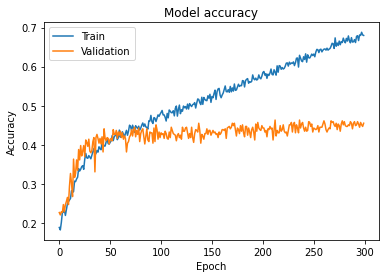

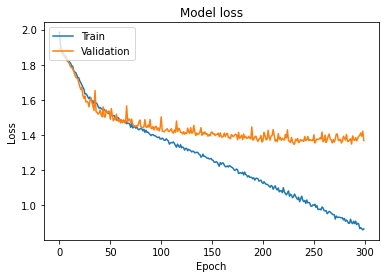

In [47]:
display_results(model1, model1_history)

## Test another model with different optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=1e-6)
model2 = build_cnn1(optimizer)
model2_history = train(model2, batch_size=16, epochs=300)

50/50 [==============================] - 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015
Train dataset accuracy: 100.00%
16/16 [==============================] - 0s 5ms/step - accuracy: 0.4347 - loss: 5.5498
Validation dataset accuracy: 43.47%
12/12 [==============================] - 0s 5ms/step - accuracy: 0.3875 - loss: 6.3263
Test dataset accuracy: 38.75%


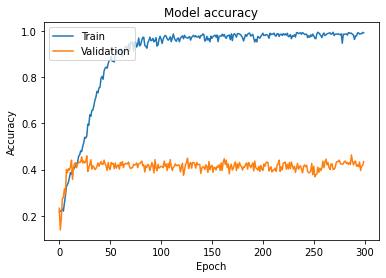

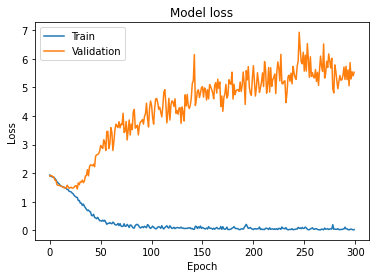

In [49]:
display_results(model2, model2_history)

## Third attempt

In [0]:
def build_cnn2(optimizer):
    with strategy.scope():
        model = Sequential()
        model.add(Conv1D(512, 5, padding='same',
                        input_shape=(216,1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(512, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=(8)))

        model.add(Conv1D(256, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(256, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=(8)))

        model.add(Conv1D(128, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(128, 5, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Flatten())
        model.add(Dropout(0.2))
        model.add(Dense(7))
        model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=1e-6)
model3 = build_cnn2(optimizer)
model3_history = train(model3, batch_size=64, epochs=60)

50/50 [==============================] - 1s 12ms/step - accuracy: 1.0000 - loss: 1.0794e-04
Train dataset accuracy: 100.00%
16/16 [==============================] - 0s 10ms/step - accuracy: 0.5367 - loss: 2.2564
Validation dataset accuracy: 53.67%
12/12 [==============================] - 0s 11ms/step - accuracy: 0.4986 - loss: 2.7065
Test dataset accuracy: 49.86%


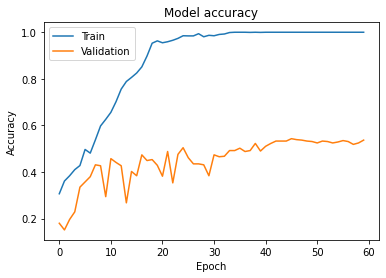

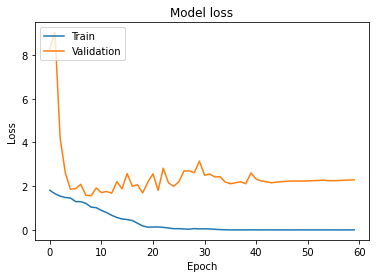

In [52]:
display_results(model3, model3_history)

## 4th attempt -> change lr from 0.001 to 0.0001

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model4 = build_cnn2(optimizer)
model4_history = train(model4, batch_size=64, epochs=60)

50/50 [==============================] - 1s 12ms/step - accuracy: 1.0000 - loss: 0.0013
Train dataset accuracy: 100.00%
16/16 [==============================] - 0s 11ms/step - accuracy: 0.4918 - loss: 1.8045
Validation dataset accuracy: 49.18%
12/12 [==============================] - 0s 11ms/step - accuracy: 0.5366 - loss: 1.6565
Test dataset accuracy: 53.66%


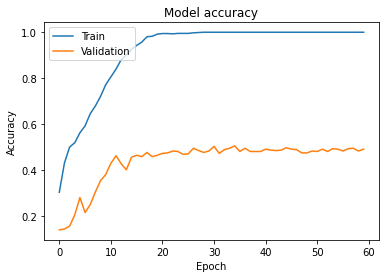

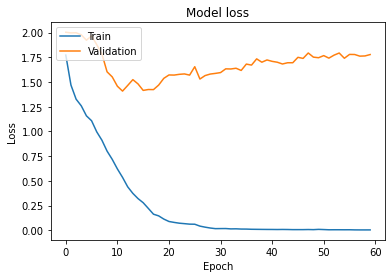

In [13]:
display_results(model4, model4_history)

## Increase number of filters

In [0]:
def build_cnn3(optimizer, l2=None):
    with strategy.scope():
        model = Sequential()
        model.add(Conv1D(512, 10, padding='same',
                        input_shape=(216,1), kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(512, 10, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=(8)))

        model.add(Conv1D(256, 20, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(256, 20, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=(8)))

        model.add(Conv1D(128, 40, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(128, 40, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Flatten())
        model.add(Dropout(0.2))
        model.add(Dense(7))
        model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model5 = build_cnn3(optimizer)
model5_history = train(model5, batch_size=64, epochs=60)

50/50 [==============================] - 1s 16ms/step - accuracy: 1.0000 - loss: 3.5979e-04
Train dataset accuracy: 100.00%
16/16 [==============================] - 0s 15ms/step - accuracy: 0.5551 - loss: 1.9276
Validation dataset accuracy: 55.51%
12/12 [==============================] - 0s 15ms/step - accuracy: 0.5772 - loss: 1.7220
Test dataset accuracy: 57.72%


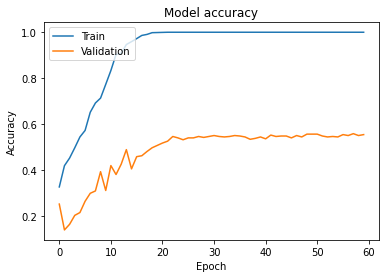

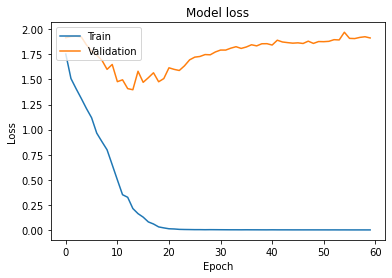

In [21]:
display_results(model5, model5_history)

## Add regularization

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
l2_regularizer = tf.keras.regularizers.l2(0.001)
model6 = build_cnn3(optimizer, l2_regularizer)
model6_history = train(model6, batch_size=64, epochs=60)

50/50 [==============================] - 1s 17ms/step - accuracy: 1.0000 - loss: 0.7838
Train dataset accuracy: 100.00%
16/16 [==============================] - 0s 16ms/step - accuracy: 0.5224 - loss: 2.7083
Validation dataset accuracy: 52.24%
12/12 [==============================] - 0s 15ms/step - accuracy: 0.5420 - loss: 2.5566
Test dataset accuracy: 54.20%


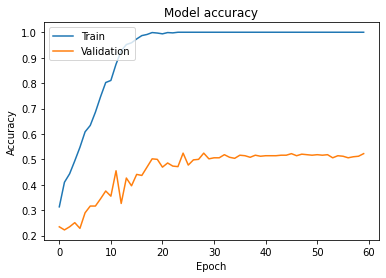

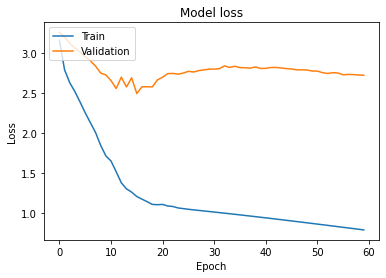

In [31]:
display_results(model6, model6_history)

## Try a model with increased number of filters and more convolution layers

In [0]:
def build_cnn4(optimizer, l2=None):
    with strategy.scope():
        model = Sequential()
        model.add(Conv1D(512, 32, padding='same',
                        input_shape=(216,1), kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(512, 32, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv1D(512, 32, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=(8)))

        model.add(Conv1D(256, 64, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(256, 64, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(256, 64, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=(8)))

        model.add(Conv1D(128, 128, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv1D(128, 128, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv1D(128, 128, padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(7))
        model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
#l2_regularizer = tf.keras.regularizers.l2(0.001)
model7 = build_cnn4(optimizer)
model7_history = train(model7, batch_size=64, epochs=60)

50/50 [==============================] - 2s 47ms/step - accuracy: 1.0000 - loss: 5.0304e-04
Train dataset accuracy: 100.00%
16/16 [==============================] - 1s 54ms/step - accuracy: 0.4796 - loss: 2.6784
Validation dataset accuracy: 47.96%
12/12 [==============================] - 1s 51ms/step - accuracy: 0.5691 - loss: 2.3408
Test dataset accuracy: 56.91%


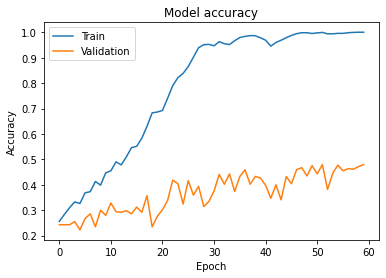

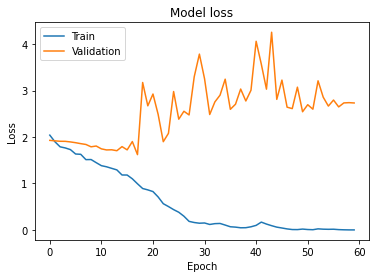

In [30]:
display_results(model7, model7_history)